In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import pandas as pd
import glob
import math
import time

In [3]:
File_path = '/bettik/bouissob/ISOMIP+/'
Bet_path = '/bettik/bouissob/'

In [4]:
os.listdir(File_path)[0:2]

['Ocean4_COM_MITgcm_JPL.nc', 'Ocean1_TYP_FVCOM.nc']

In [5]:
Data_Name = '*COM_NEMO-CNRS.nc'
paths = glob.glob(File_path + Data_Name)

In [6]:
paths

['/bettik/bouissob/ISOMIP+/Ocean1_COM_NEMO-CNRS.nc',
 '/bettik/bouissob/ISOMIP+/Ocean4_COM_NEMO-CNRS.nc',
 '/bettik/bouissob/ISOMIP+/Ocean3_COM_NEMO-CNRS.nc',
 '/bettik/bouissob/ISOMIP+/Ocean2_COM_NEMO-CNRS.nc']

Dans NN, var en x pour simul y<br>
x : T, S, x, y, z<br>
y : MeltRate<br>
1ere Étape : Preparer les données

In [7]:
def get_depth_temp_sali(df, Data, zs):
    ys, IceDraft = df.ny, df.iceDraft
    N_T, N_S = [], []
    ylast = None
    dataset = Data[['temperatureYZ', 'salinityYZ']].to_dataframe().dropna()
    Index_Y = dataset.index.get_level_values('ny')
    for ind, y in enumerate(ys):
        indz = np.abs(np.array(zs + IceDraft[ind])).argmin()
        if y != ylast:
            Slice = dataset.iloc[Index_Y == y].droplevel('ny')
        Z_N = abs(np.array(Slice.index - indz)).argmin() + Slice.index[0]
        New_T = dataset.temperatureYZ.loc[Z_N, y]
        New_S = dataset.salinityYZ.loc[Z_N, y]
        N_T.append(New_T)
        N_S.append(New_S)
    return np.array(N_T), np.array(N_S)

In [8]:
def New_get_depth_temp_sal(df, Data):
    ys, Icedraft = np.array(df.ny), np.array(df.iceDraft)
    Var = ['temperatureYZ', 'salinityYZ']
    y = xr.DataArray(ys)
    iceZ = xr.DataArray(Icedraft)
    Data = Data.assign_coords({'nz':  - Data.nz})
    Filled = Data[Var].interpolate_na(dim="nz", use_coordinate = True, method = 'nearest', fill_value="extrapolate")
    Cur = Filled[Var].interp(ny = y, nz = iceZ, method = 'nearest')
    T, S = np.array(Cur.to_array())
    return T, S


In [9]:
for path in paths[0:1]:
    dfT = pd.DataFrame()
    Name = path.replace('.nc', '').replace(File_path, '')
    print(path)
    Data = xr.open_dataset(path)
    Data = Data.assign_coords({'nx': Data.x,
                           'ny': Data.y,
                           'nz': Data.z,
                           'nTime': Data.time})
    T = np.array(Data.nTime.as_numpy())
    Horiz_resol = 2 #km/index
    XstartYZ = int(500 / Horiz_resol)
    YstartXZ = int(40 / Horiz_resol)
    Time = len(T)
    Start = time.perf_counter()
    T = []
    df = []
    for t in range(Time):
        if (t+1)%int(Time/10) == 0:
            print('Starting {} / {}    '.format(t+1, Time), end = '\r')
        df = pd.DataFrame()
        df['meltRate'] = (Data['meltRate'].isel(nTime = t).to_dataframe())['meltRate']
        df['thermalDriving'] = Data['thermalDriving'].isel(nTime = t).to_dataframe()['thermalDriving']
        df['halineDriving'] = Data['halineDriving'].isel(nTime = t).to_dataframe()['halineDriving']
        if Data['iceDraft'].ndim == 2:
            df['iceDraft'] = Data['iceDraft'].to_dataframe()['iceDraft']
        else:
            df['iceDraft'] = Data['iceDraft'].isel(nTime = t).to_dataframe()['iceDraft']
        df['date'] = t
        df.dropna(inplace = True)
        df.reset_index(inplace=True)
        T, S = New_get_depth_temp_sal(df, Data.isel(nTime = t))
        #T, S = get_depth_temp_sali(df, Data.isel(nTime = t), Data.z.to_dataframe())
        df['temperatureYZ'] = T
        df['salinityYZ'] = S
        dfT = pd.concat([dfT, df], ignore_index = True)

    print('Done in {} s'.format(time.perf_counter() - Start))
    d = pd.DataFrame(dfT)
    dfT.dropna(inplace = True)
    dfT.reset_index(drop = True, inplace = True)
    dfT.rename(columns={'nx' :'x', 'ny': 'y'}, inplace=True)
    dfT['x'] = dfT['x'] * Horiz_resol
    dfT['y'] = dfT['y'] * Horiz_resol
    #pd.DataFrame.to_csv(dfT, Bet_path + 'Data/data_{}.csv'.format(Name), index = False)

/bettik/bouissob/ISOMIP+/Ocean1_COM_NEMO-CNRS.nc
Done in 21.2300466769957 s


In [255]:
Ancien = pd.read_csv(Bet_path + 'Data/data_{}.csv'.format(Name))
Nouveau = dfT

In [256]:
Nv = Nouveau.set_index(['x', 'y', 'date'])
Ac = Ancien.set_index(['x', 'y', 'date'])

In [257]:
Diff = pd.DataFrame(Nouveau['temperatureYZ'] - Ancien['temperatureYZ'])
Diff['x'] = Nouveau['x']
Diff['y'] = Nouveau['y']
Diff['date'] = Nouveau['date']
Diff = Diff.set_index(['x', 'y', 'date']).to_xarray()

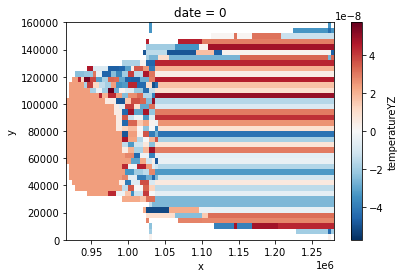

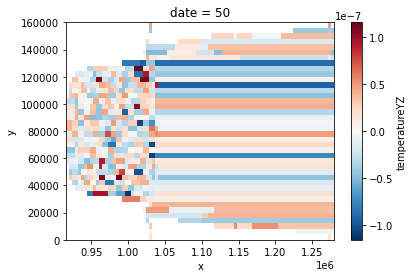

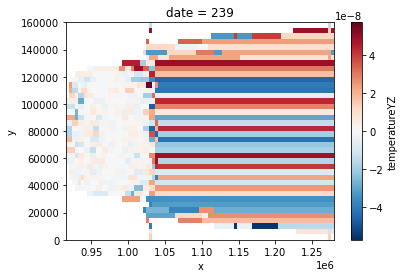

In [258]:
Diff.temperatureYZ.isel(date = 0).plot(x = 'x')
plt.figure()
Diff.temperatureYZ.isel(date = 50).plot(x = 'x')
plt.figure()
Diff.temperatureYZ.isel(date = 239).plot(x = 'x')

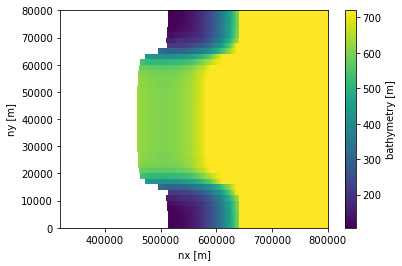

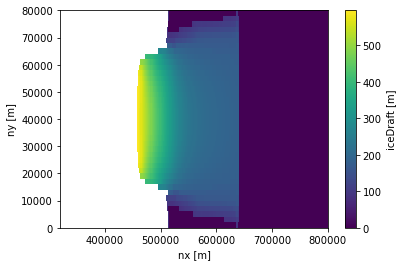

In [259]:
Data.bathymetry.plot()
plt.figure()
Data.iceDraft.plot()

In [260]:
#np.isnan(Data.iceDraft)

In [261]:
Test = Data.isel(nTime = 239).iceDraft.fillna(-9999)
Test2 = Data.isel(nTime = 239).meltRate.fillna(-2)

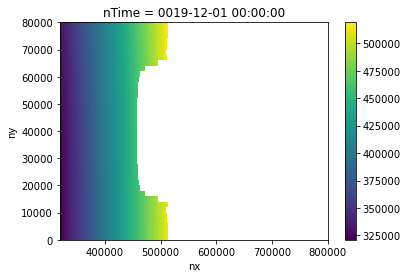

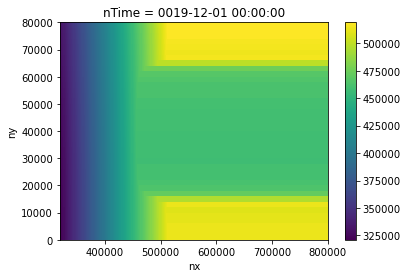

In [293]:
T = xr.where(Test == -9999, 1, 2)
B = xr.where(Test == -9999, np.sqrt(Test.nx**2 + Test.ny**2), np.nan)
B.plot()
A = B.interpolate_na(dim="ny", use_coordinate = True, method = 'nearest', fill_value='extrapolate')
plt.figure()
#A.plot()
#plt.figure()
#C = A.interpolate_na(dim="nx", use_coordinate = True, method = 'nearest', fill_value='extrapolate')
#C.plot()
D = B.interpolate_na(dim="nx", use_coordinate = True, method = 'nearest', fill_value='extrapolate')
D.plot()

#Data.isel(nTime = 239).iceDraft.where(~Data.iceDraft.notnull()).plot()
#Data[Var].interpolate_na(dim="nz", use_coordinate = True, method = 'nearest', fill_value="extrapolate")
#B.interp(method = 'nearest',kwargs={"fill_value": "extrapolate"}) -999

Potentiellement bon

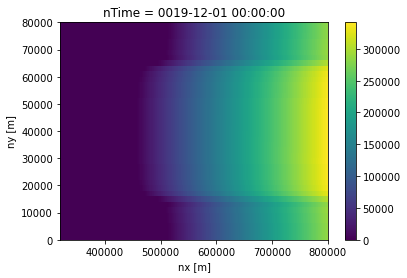

In [297]:
Interp_dist = D
Dist_ti_ground = np.sqrt(Test.nx**2 + Test.ny**2) - Interp_dist
Dist_ti_ground.plot(x = 'nx')

In [187]:
T2 = T.where(T == 2).to_dataframe().dropna().reset_index()
T3 = T.where(T == 1).to_dataframe().dropna().reset_index()
#xr.where(T == 2, T, T.interp(nx = x , ny = y, method = 'nearest',kwargs={"fill_value": "extrapolate"}))

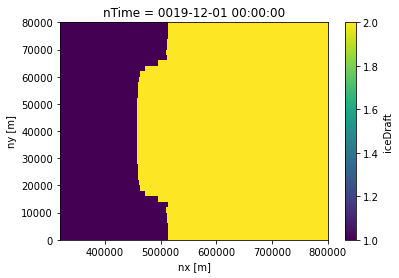

In [250]:
T.plot()
#np.sqrt(Test.nx**2 + Test.ny**2).plot()

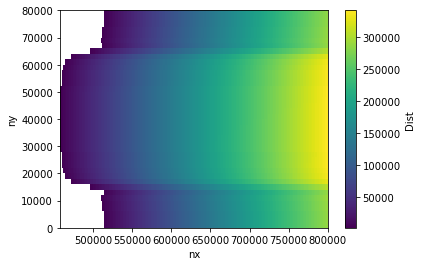

In [236]:
x = xr.DataArray(T2.nx.values)
y = xr.DataArray(T2.ny.values)
Cur = Dist_ti_ground.interp(nx = x, ny = y, method = 'linear', kwargs = {"bounds_error":False})#,kwargs={"fill_value": "extrapolate"})
Cur = Cur.to_dataframe(name = 'Dist').set_index(['nx', 'ny']).to_xarray()
Cur.Dist.plot(x = 'nx')

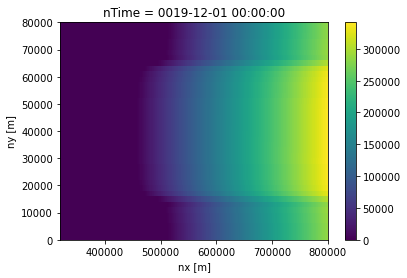

In [229]:
Dist_ti_ground.plot(x = 'nx')

In [233]:
slice(0, 10)

slice(0, 10, None)

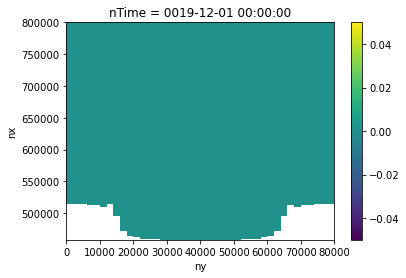

In [242]:
(Cur.Dist - Dist_ti_ground).plot()

In [239]:
Cur

<xarray.Dataset>
Dimensions:  (nx: 171, ny: 40)
Coordinates:
  * nx       (nx) float64 4.59e+05 4.61e+05 4.63e+05 ... 7.97e+05 7.99e+05
  * ny       (ny) float64 1e+03 3e+03 5e+03 7e+03 ... 7.5e+04 7.7e+04 7.9e+04
Data variables:
    nTime    (nx, ny) object nan nan ... 0019-12-01 00:00:00 0019-12-01 00:00:00
    Dist     (nx, ny) float64 nan nan nan nan ... 2.841e+05 2.84e+05 2.838e+05